
In this notebook, You will do amazon review classification with BERT.[Download data from [this](https://www.kaggle.com/snap/amazon-fine-food-reviews/data) link]
<pre> 
It contains 5 parts as below.  Detailed instrctions are given in the each cell. please read every comment we have written. 
    1. Preprocessing 
    2. Creating a BERT model from the Tensorflow HUB.
    3. Tokenization
    4. getting the pretrained embedding Vector for a given review from the BERT.
    5. Using the embedding data apply NN and classify the reviews.
    6. Creating a Data pipeline for BERT Model. 

<font size=5>instructions:</font>

    1. Don't change any Grader Functions. Don't manipulate any Grader functions. 
    If you manipulate any, it will be considered as plagiarised. 
    
    2. Please read the instructions on the code cells and markdown cells. We will explain what to write. 
    
    3. please return outputs in the same format what we asked. Eg. Don't return List if we are asking for a numpy array.
    
    4. Please read the external links that we are given so that you will learn the concept behind the code that you are writing.
    
    5. We are giving instructions at each section if necessary, please follow them. 

<font size=5>Every Grader function has to return True. </font>
</pre>

In [1]:
#in this assignment you need two files reviews.csv and tokenization file
#you can use gdown module to import both the files in colab from Google drive
#the syntax is for gdown is !gdown --id file_id
#please run the below cell to import the required files


In [2]:
# !gdown --id 1GsD8JlAc_0yJ-1151LNr6rLw83RRUPgt
# !gdown --id 13exfXiyiByluh1PfYK1EyZyizqxeCVG9

In [1]:
#all imports
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Model

In [2]:
gpu = tf.config.experimental.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(gpu[0], True)

In [5]:
os.chdir(r'D:\Applied_AI\Aass_28')

In [6]:
tf.test.gpu_device_name()

'/device:GPU:0'

<font size=4>Grader function 1 </font>

In [7]:
def grader_tf_version():
    assert((tf.__version__)>'2')
    return True
grader_tf_version()

True

<pre><font size=6>Part-1: Preprocessing</font></pre>

In [8]:
#Read the dataset - Amazon fine food reviews
reviews = pd.read_csv(r"Reviews.csv")
#check the info of the dataset
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [9]:
reviews.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


In [10]:
#get only 2 columns - Text, Score
#drop the NAN values

In [11]:
df = reviews[['Text','Score']]
df.head(2),df.shape

(                                                Text  Score
 0  I have bought several of the Vitality canned d...      5
 1  Product arrived labeled as Jumbo Salted Peanut...      1,
 (568454, 2))

In [13]:
reviews = df.drop(df[df['Score']==3].index)

In [14]:
reviews.loc[reviews['Score'] < 3,'Score'] = 0
reviews.loc[reviews['Score'] > 3,'Score'] = 1


In [15]:
reviews.head(2)

,Text,Score
0,I have bought several of the Vitality canned d...,1
1,Product arrived labeled as Jumbo Salted Peanut...,0


In [16]:
reviews.shape

(525814, 2)

<font size=4>Grader function 2 </font>

In [17]:
def grader_reviews():
    temp_shape = (reviews.shape == (525814, 2)) and (reviews.Score.value_counts()[1]==443777)
    assert(temp_shape == True)
    return True
grader_reviews()

True

In [18]:
def get_wordlen(x):
    return len(x.split())
reviews['len'] = reviews.Text.apply(get_wordlen)
reviews = reviews[reviews.len<50]
reviews = reviews.sample(n=100000, random_state=30)

In [19]:
#remove HTML from the Text column and save in the Text column only

In [20]:
import re
reviews['Text'] = [re.sub(r'<[^<]+?','', text) for text in reviews['Text']]

In [21]:
#print head 5

In [22]:
reviews.head(5)

,Text,Score,len
64117,The tea was of great quality and it tasted lik...,1,30
418112,My cat loves this. The pellets are nice and s...,1,31
357829,Great product. Does not completely get rid of ...,1,41
175872,This gum is my favorite! I would advise every...,1,27
178716,I also found out about this product because of...,1,22


In [23]:
#split the data into train and test data(20%) with Stratify sampling, random state 33, 

In [24]:
X = reviews.drop(['Score'],axis=1)
y = reviews['Score']

In [25]:
X.head(2)

,Text,len
64117,The tea was of great quality and it tasted lik...,30
418112,My cat loves this. The pellets are nice and s...,31


In [26]:
y.head(2)

64117     1
418112    1
Name: Score, dtype: int64

In [27]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=33,stratify=y)

In [28]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((80000, 2), (20000, 2), (80000,), (20000,))

In [29]:
#plot bar graphs of y_train and y_test

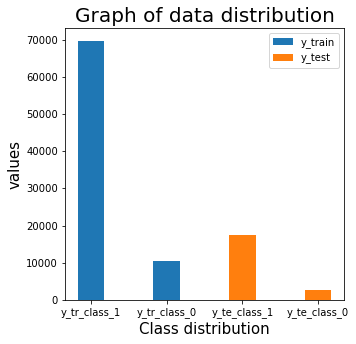

In [30]:
import matplotlib.pyplot as plt
data_tr = {'y_tr_class_1':y_train.value_counts()[1],'y_tr_class_0':y_train.value_counts()[0]}
data_te = {'y_te_class_1':y_test.value_counts()[1],'y_te_class_0':y_test.value_counts()[0]}
fig = plt.figure(figsize=(5,5))
bar1 = plt.bar(data_tr.keys(),data_tr.values(),width=0.35)
bar2 = plt.bar(data_te.keys(),data_te.values(),width=0.35)

plt.xlabel('Class distribution',fontsize = 15)
plt.ylabel('values',fontsize = 15)
plt.title('Graph of data distribution',fontsize = 20)
plt.legend((bar1,bar2),('y_train','y_test'))
plt.show()


In [31]:
#saving to disk. if we need, we can load preprocessed data directly. 
reviews.to_csv('preprocessed.csv', index=False)

<pre><font size=6>Part-2: Creating BERT Model</font> 

If you want to know more about BERT, You can watch live sessions on Transformers and BERt. 
we will strongly recommend you to read <a href="https://jalammar.github.io/illustrated-transformer/">Transformers</a>, <a href="https://arxiv.org/abs/1810.04805">BERT Paper</a> and, <a href="https://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/">This blog</a>.


For this assignment, we are using <a href="https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1">BERT uncased Base model</a>. 
It uses L=12 hidden layers (i.e., Transformer blocks), a hidden size of H=768, and A=12 attention heads. </pre>

In [32]:
## Loading the Pretrained Model from tensorflow HUB
tf.keras.backend.clear_session()

# maximum length of a seq in the data we have, for now i am making it as 55. You can change this
max_seq_length = 55

#BERT takes 3 inputs

#this is input words. Sequence of words represented as integers
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")

#mask vector if you are padding anything
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")

#segment vectors. If you are giving only one sentence for the classification, total seg vector is 0. 
#If you are giving two sentenced with [sep] token separated, first seq segment vectors are zeros and 
#second seq segment vector are 1's
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")

#bert layer 
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=False)
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

#Bert model
#We are using only pooled output not sequence out. 
#If you want to know about those, please read https://www.kaggle.com/questions-and-answers/86510
bert_model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=pooled_output)


In [33]:
bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 55)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 55)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 55)]         0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [34]:
bert_model.output

<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'keras_layer')>

<pre><font size=6>Part-3: Tokenization</font></pre>

In [33]:
#getting Vocab file
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

In [36]:
os.getcwd()

'd:\\Applied_AI\\Aass_28'

In [37]:
# conda install sentencepiece

In [34]:
import tokenization #We have given tokenization.py file

In [39]:
# Create tokenizer " Instantiate FullTokenizer" 
# name must be "tokenizer"
# the FullTokenizer takes two parameters 1. vocab_file and 2. do_lower_case 
# we have created these in the above cell ex: FullTokenizer(vocab_file, do_lower_case )
# please check the "tokenization.py" file the complete implementation


In [35]:
# if you are getting error for sentencepiece module you can install it using below command while running this cell for the first time
#!pip install sentencepiece
tokenizer=tokenization.FullTokenizer(vocab_file,do_lower_case )

<font size=4>Grader function 3 </font>

In [41]:
#it has to give no error 
def grader_tokenize(tokenizer):
    out = False
    try:
        out=('[CLS]' in tokenizer.vocab) and ('[SEP]' in tokenizer.vocab)
    except:
        out = False
    assert(out==True)
    return out
grader_tokenize(tokenizer)

True

In [42]:
# Create train and test tokens (X_train_tokens, X_test_tokens) from (X_train, X_test) using Tokenizer and 

# add '[CLS]' at start of the Tokens and '[SEP]' at the end of the tokens. 

# maximum number of tokens is 55(We already given this to BERT layer above) so shape is (None, 55)

# if it is less than 55, add '[PAD]' token else truncate the tokens length.(similar to padding)

# Based on padding, create the mask for Train and Test ( 1 for real token, 0 for '[PAD]'), 
# it will also same shape as input tokens (None, 55) save those in X_train_mask, X_test_mask

# Create a segment input for train and test. We are using only one sentence so all zeros. This shape will also (None, 55)

# type of all the above arrays should be numpy arrays

# after execution of this cell, you have to get 
# X_train_tokens, X_train_mask, X_train_segment
# X_test_tokens, X_test_mask, X_test_segment

#### Example
<img src='https://i.imgur.com/5AhhmgU.png'>

In [43]:
X_train.values[0][0]

'I had never tried this brand before, so I was worried about the quality.  It tasted great.  A very nice smooth rich full flavor.  Its my new favoret.'

In [44]:
print('original sentence : \n',X_train.values[0][0].split())
print('Number of words : ',len(X_train.values[0][0].split()))
print('*'*100)
tokens = tokenizer.tokenize(X_train.values[0][0])
tokens = tokens[:(max_seq_length-2)]
tokens = ['[CLS]',*tokens,'[SEP]']
print('tokens are : \n',tokens) 
print('*'*100)
print('Number of tokens : ',len(tokens))
print('tokens replaced with posional encoding : \n',np.array(tokenizer.convert_tokens_to_ids(tokens)))
print('*'*100)
print('the mask array is : ',np.array([1]*len(tokens)+[0]*(max_seq_length-len(tokens))))
print('*'*100)
print('The segment array is : ',np.array([0]*max_seq_length))
print('*'*100)


original sentence : 
 ['I', 'had', 'never', 'tried', 'this', 'brand', 'before,', 'so', 'I', 'was', 'worried', 'about', 'the', 'quality.', 'It', 'tasted', 'great.', 'A', 'very', 'nice', 'smooth', 'rich', 'full', 'flavor.', 'Its', 'my', 'new', 'favoret.']
Number of words :  28
****************************************************************************************************
tokens are : 
 ['[CLS]', 'i', 'had', 'never', 'tried', 'this', 'brand', 'before', ',', 'so', 'i', 'was', 'worried', 'about', 'the', 'quality', '.', 'it', 'tasted', 'great', '.', 'a', 'very', 'nice', 'smooth', 'rich', 'full', 'flavor', '.', 'its', 'my', 'new', 'favor', '##et', '.', '[SEP]']
****************************************************************************************************
Number of tokens :  36
tokens replaced with posional encoding : 
 [  101  1045  2018  2196  2699  2023  4435  2077  1010  2061  1045  2001
  5191  2055  1996  3737  1012  2009 12595  2307  1012  1037  2200  3835
  5744  4138  2440 

In [45]:
X_train.reset_index(inplace = True)
X_test.reset_index(inplace = True)

In [46]:
X_tr_txt = X_train.Text
X_te_txt = X_test.Text
X_tr_txt.shape,X_te_txt.shape

((80000,), (20000,))

In [47]:
def token():
    X_train_tokens = []
    X_test_tokens = []

    X_train_mask = []
    X_test_mask = []

    X_train_segment = []
    X_test_segment = []



    for i in range(len(X_tr_txt)):
        tkn0 = tokenizer.tokenize(X_tr_txt.values[i])
        if len(tkn0) < max_seq_length:
            tkn1 = tkn0[0:(max_seq_length-2)]
            tkn2 = ['[CLS]', *tkn1, '[SEP]']        
            tokens = [*tkn2, *['[PAD]']*(max_seq_length-len(tkn2))]
            mask = [*[1]*len(tkn2), *[0]*(max_seq_length-len(tkn2))]

        elif len(tkn0) >= max_seq_length: 
            tkn1 = tkn0[0:(max_seq_length-2)]
            tokens = ['[CLS]', *tkn1, '[SEP]']
            mask = [*[1]*max_seq_length]
        X_train_tokens.append(tokenizer.convert_tokens_to_ids(tokens))
        X_train_mask.append(mask)
        X_train_segment.append(np.array([0]*max_seq_length))

    for i in range(len(X_te_txt)):
        tkn0 = tokenizer.tokenize(X_te_txt.values[i])
        if len(tkn0) < max_seq_length:
            tkn1 = tkn0[0:(max_seq_length-2)]
            tkn2 = ['[CLS]', *tkn1, '[SEP]']        
            tokens = [*tkn2, *['[PAD]']*(max_seq_length-len(tkn2))]
            mask = [*[1]*len(tkn2), *[0]*(max_seq_length-len(tkn2))]

        elif len(tkn0) >= max_seq_length: 
            tkn1 = tkn0[0:(max_seq_length-2)]
            tokens = ['[CLS]', *tkn1, '[SEP]']
            mask = [*[1]*max_seq_length]
        X_test_tokens.append(tokenizer.convert_tokens_to_ids(tokens))
        X_test_mask.append(mask)
        X_test_segment.append(np.array([0]*max_seq_length))
    return np.array(X_train_tokens),np.array(X_test_tokens),np.array(X_train_mask),np.array(X_test_mask),np.array(X_train_segment),np.array(X_test_segment)


        

In [48]:
 X_train_tokens,X_test_tokens,X_train_mask,X_test_mask,X_train_segment,X_test_segment = token()


In [50]:
##save all your results to disk so that, no need to run all again. 
import pickle
pickle.dump((X_train, X_train_tokens, X_train_mask, X_train_segment, y_train),open('train_data.pkl','wb'))
pickle.dump((X_test, X_test_tokens, X_test_mask, X_test_segment, y_test),open('test_data.pkl','wb'))

In [3]:
# you can load from disk
import pickle
X_train, X_train_tokens, X_train_mask, X_train_segment, y_train = pickle.load(open("train_data.pkl", 'rb')) 
X_test, X_test_tokens, X_test_mask, X_test_segment, y_test = pickle.load(open("test_data.pkl", 'rb')) 

<font size=4>Grader function 4 </font>

In [51]:
def grader_alltokens_train():
    out = False
    
    if type(X_train_tokens) == np.ndarray:
        
        temp_shapes = (X_train_tokens.shape[1]==max_seq_length) and (X_train_mask.shape[1]==max_seq_length) and \
        (X_train_segment.shape[1]==max_seq_length)
        
        segment_temp = not np.any(X_train_segment)
        
        mask_temp = np.sum(X_train_mask==0) == np.sum(X_train_tokens==0)
        
        no_cls = np.sum(X_train_tokens==tokenizer.vocab['[CLS]'])==X_train_tokens.shape[0]
        
        no_sep = np.sum(X_train_tokens==tokenizer.vocab['[SEP]'])==X_train_tokens.shape[0]
        
        out = temp_shapes and segment_temp and mask_temp and no_cls and no_sep
      
    else:
        print('Type of all above token arrays should be numpy array not list')
        out = False
    assert(out==True)
    return out

grader_alltokens_train()

True

<font size=4>Grader function 5 </font>

In [52]:
def grader_alltokens_test():
    out = False
    if type(X_test_tokens) == np.ndarray:
        
        temp_shapes = (X_test_tokens.shape[1]==max_seq_length) and (X_test_mask.shape[1]==max_seq_length) and \
        (X_test_segment.shape[1]==max_seq_length)
        
        segment_temp = not np.any(X_test_segment)
        
        mask_temp = np.sum(X_test_mask==0) == np.sum(X_test_tokens==0)
        
        no_cls = np.sum(X_test_tokens==tokenizer.vocab['[CLS]'])==X_test_tokens.shape[0]
        
        no_sep = np.sum(X_test_tokens==tokenizer.vocab['[SEP]'])==X_test_tokens.shape[0]
        
        out = temp_shapes and segment_temp and mask_temp and no_cls and no_sep
      
    else:
        print('Type of all above token arrays should be numpy array not list')
        out = False
    assert(out==True)
    return out
grader_alltokens_test()

True

<pre><font size=6>Part-4: Getting Embeddings from BERT Model</font>
We already created the BERT model in the part-2 and input data in the part-3. 
We will utlize those two and will get the embeddings for each sentence in the 
Train and test data.</pre>

In [53]:
bert_model.input

[<KerasTensor: shape=(None, 55) dtype=int32 (created by layer 'input_word_ids')>,
 <KerasTensor: shape=(None, 55) dtype=int32 (created by layer 'input_mask')>,
 <KerasTensor: shape=(None, 55) dtype=int32 (created by layer 'segment_ids')>]

In [54]:
bert_model.output

<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'keras_layer')>

In [55]:
# get the train output, BERT model will give one output so save in
# X_train_pooled_output
#this cell will take some time to execute, make sure thay you have stable internet connection
X_train_pooled_output=bert_model.predict([X_train_tokens,X_train_mask,X_train_segment])

In [56]:
# get the test output, BERT model will give one output so save in
# X_test_pooled_output
X_test_pooled_output=bert_model.predict([X_test_tokens,X_test_mask,X_test_segment])

In [57]:
##save all your results to disk so that, no need to run all again. 
pickle.dump((X_train_pooled_output, X_test_pooled_output),open('final_output.pkl','wb'))

In [4]:
import pickle
X_train_pooled_output, X_test_pooled_output= pickle.load(open('final_output.pkl', 'rb'))

<font size=4>Grader function 6 </font>

In [58]:
#now we have X_train_pooled_output, y_train
#X_test_pooled_ouput, y_test

#please use this grader to evaluate
def greader_output():
    assert(X_train_pooled_output.shape[1]==768)
    assert(len(y_train)==len(X_train_pooled_output))
    assert(X_test_pooled_output.shape[1]==768)
    assert(len(y_test)==len(X_test_pooled_output))
    assert(len(y_train.shape)==1)
    assert(len(X_train_pooled_output.shape)==2)
    assert(len(y_test.shape)==1)
    assert(len(X_test_pooled_output.shape)==2)
    return True
greader_output()

True

<pre><font size=6>Part-5: Training a NN with 768 features</font>

Create a NN and train the NN. 
1.<b> You have to use AUC as metric. Do not use tf.keras.metrics.AUC</b> 
<b> You have to write custom code for AUC and print it at the end of each epoch</b> 
2. You can use any architecture you want. 
3. You have to use tensorboard to log all your metrics and Losses. You have to send those logs. 
4. Print the loss and metric at every epoch. 
5. You have to submit without overfitting and underfitting. 
</pre>

In [5]:
##imports
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, LSTM
from tensorflow.keras.models import Model

In [6]:
##create an Neural Network and train your model on X_train_pooled_output and y_train
# you can start as follows
#input_layer=Input(shape=(X_train_pooled_output.shape[1],))

In [7]:
from sklearn.metrics import roc_auc_score
def auroc(y_tr, y_pred):
    return tf.py_function(auc, (y_tr, y_pred), tf.double)

def auc(y_train, y_pred):
    if len(np.unique(y_train[:,1])) == 1:
        return 0.5
    else:
        return roc_auc_score(y_train, y_pred)

In [8]:
from keras.utils import np_utils

y_train_nw = np_utils.to_categorical(y_train, 2) 
y_test_nw = np_utils.to_categorical(y_test, 2)

In [9]:
from keras import regularizers
from keras.initializers import he_normal
from keras.layers import LSTM, SpatialDropout1D, BatchNormalization,concatenate,Flatten,Embedding,Dense,Dropout,MaxPooling2D,Reshape, Conv1D
from tensorflow.python.keras.callbacks import TensorBoard
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.layers import Conv3D, MaxPool2D, Flatten, Conv2D, Embedding

In [10]:
input=Input(shape=(X_train_pooled_output.shape[1],))
output = Dense(2, activation='softmax', name='output')(input)

In [11]:
# . When padding="same" and strides=1, the output has the same size as the input.

In [12]:
model_1 = Model(inputs=[input], outputs=[output])
model_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 768)]             0         
_________________________________________________________________
output (Dense)               (None, 2)                 1538      
Total params: 1,538
Trainable params: 1,538
Non-trainable params: 0
_________________________________________________________________


In [13]:
!rm -rf ./logs

In [14]:
os.chdir(r'D:\Applied_AI\Aass_28\New folder')

In [15]:
checkpoint = ModelCheckpoint("NLP_tr_learn.h5", monitor="val_auroc", mode="max", save_best_only=True, verbose=2)
earlystop = EarlyStopping(monitor = 'val_auroc', patience = 3, mode="max",min_delta = 0, verbose = 2)
logs = 'logs4'
tensorboard = TensorBoard(log_dir=logs)

In [16]:
model_1.compile(loss='categorical_crossentropy', optimizer='Adam',  metrics=[auroc])

In [17]:
model_1.fit(X_train_pooled_output,
    y_train_nw,
    epochs=30,
    validation_data=(X_test_pooled_output, y_test_nw),
    batch_size=64,
    verbose=True,
    callbacks=[checkpoint,earlystop,tensorboard])


Epoch 1/30
1250/1250 [==============================] - 8s 5ms/step - loss: 0.2903 - auroc: 0.8653 - val_loss: 0.2428 - val_auroc: 0.9150

Epoch 00001: val_auroc improved from -inf to 0.91500, saving model to NLP_tr_learn.h5
Epoch 2/30
1250/1250 [==============================] - 4s 3ms/step - loss: 0.2276 - auroc: 0.9290 - val_loss: 0.2165 - val_auroc: 0.9308

Epoch 00002: val_auroc improved from 0.91500 to 0.93076, saving model to NLP_tr_learn.h5
Epoch 3/30
1250/1250 [==============================] - 4s 3ms/step - loss: 0.2109 - auroc: 0.9381 - val_loss: 0.2053 - val_auroc: 0.9362

Epoch 00003: val_auroc improved from 0.93076 to 0.93617, saving model to NLP_tr_learn.h5
Epoch 4/30
1250/1250 [==============================] - 4s 3ms/step - loss: 0.2023 - auroc: 0.9424 - val_loss: 0.2046 - val_auroc: 0.9382

Epoch 00004: val_auroc improved from 0.93617 to 0.93824, saving model to NLP_tr_learn.h5
Epoch 5/30
1250/1250 [==============================] - 4s 4ms/step - loss: 0.1963 - auroc:

In [18]:
%load_ext tensorboard

In [20]:
%tensorboard --logdir logs4

Reusing TensorBoard on port 6006 (pid 14340), started 0:00:04 ago. (Use '!kill 14340' to kill it.)

In [137]:
!rm -rf ./logs/

Part-6: Creating a Data pipeline for BERT Model 
1. Pipeline is a way to codify and automate the workflow.
2. Download the test.csv file from here here 

In [25]:
#there is an alterante way to load files from Google drive directly to your Colab session
# you can use gdown module to import the files as follows
#for example for test.csv you can write your code as !gdown --id file_id (remove the # from next line and run it)

In [21]:
os.chdir(r'D:\Applied_AI\Aass_28')

In [22]:
#read the csv file
test_df= pd.read_csv('test.csv')

<Pre>1. You have to write a function that takes the test_df,trained model and the required parameters as input. 
2. Perform all the preproceesing steps inside the function.
- Remove all the html tags
- Now do tokenization [Part 3 as mentioned above]
- Create tokens,mask array and segment array
- Get Embeddings from BERT Model [Part 4 as mentioned above] , let it be X_test
- Print the shape of output(X_test.shape).You should get (352,768)
3. Predit the output of X_test with the neural network model which we trained earlier.

4. Return the occurences of class labels from the function.
The output should be the count of datapoints classified as 1 or 0.

</pre>

In [26]:
class Transformer:

  def __init__(self, test_data, classifier):
    self.test_data = test_data
    self.classifier = classifier

  def pre_process(self, test_data):
    def remove_html_tag(file):
      sent = re.sub(r'(<.*>)' , '', file)
      return sent
    self.test_data['Text'] = self.test_data['Text'].apply(remove_html_tag)
    
    tokens_test = []
    mask_test = []
    segment_test = []
    for i in range(len(self.test_data)):
        tkn0 = tokenizer.tokenize(self.test_data['Text'].values[i])
        if len(tkn0) >= max_seq_length:    
            tkn1 = tkn0[0:(max_seq_length-2)]
            tokens = ['[CLS]', *tkn1, '[SEP]']
            mask = [*[1]*max_seq_length]
        elif len(tkn0) < max_seq_length:
            tkn1 = tkn0[0:(max_seq_length-2)]
            tokens2 = ['[CLS]', *tkn1, '[SEP]']        
            tokens = [*tokens2, *['[PAD]']*(max_seq_length-len(tokens2))]
            mask = [*[1]*len(tokens2), *[0]*(max_seq_length-len(tokens2))]
        tokens_test.append(tokenizer.convert_tokens_to_ids(tokens))
        mask_test.append(mask)
        segment_test.append(np.array([0]*max_seq_length))\

    tok_test = np.array(tokens_test)
    mas_test = np.array(mask_test)
    seg_test = np.array(segment_test)
    X_test = bert_model.predict([tok_test, mas_test, seg_test])
#     print(X_test.shape)
    return X_test
    
    # input_ = bert_layer.input_

  def classifier(self, X_test):
    return self.classifier.predict([X_test])

  def predict_labels(self):
    
    input_ = self.pre_process(self.test_data)
    output_ = self.classifier(input_)
    return(output_)


In [36]:
import re
pipe_line = Transformer(test_df, model_1)
pipe_line.predict_labels()

<tf.Tensor: shape=(352, 2), dtype=float32, numpy=
array([[8.78480971e-01, 1.21518992e-01],
       [3.61322938e-03, 9.96386766e-01],
       [3.96517128e-01, 6.03482902e-01],
       [1.87921837e-01, 8.12078118e-01],
       [5.17334556e-03, 9.94826615e-01],
       [4.52210009e-01, 5.47789991e-01],
       [8.83625150e-01, 1.16374850e-01],
       [1.31705194e-03, 9.98682916e-01],
       [1.05842995e-03, 9.98941600e-01],
       [1.14572828e-03, 9.98854280e-01],
       [3.67057294e-01, 6.32942677e-01],
       [1.15615381e-02, 9.88438427e-01],
       [7.63591051e-01, 2.36408919e-01],
       [2.49335572e-01, 7.50664413e-01],
       [7.28447139e-02, 9.27155256e-01],
       [9.86350358e-01, 1.36496825e-02],
       [2.14633346e-03, 9.97853696e-01],
       [1.22743961e-03, 9.98772562e-01],
       [3.60623859e-02, 9.63937581e-01],
       [3.14159580e-02, 9.68584061e-01],
       [1.35752678e-01, 8.64247382e-01],
       [6.84313551e-02, 9.31568623e-01],
       [2.24997163e-01, 7.75002897e-01],
       

## Please write your observations at the end of notebook and  explain each and every step you followed in solving this assignment.

# Observations
### Part 1
Step 1. Imported all files.

Step 2. In prepocessing step we kept two columns i.e. 'Score' and 'Text'.

Srep 3. Removed rows where score = 3 and assigned score = 0 and 1 for score <3 and score > 3 respectively.

Step 4. Splitted data into train and test data sets.

Step 5. From the bar graph we can observe that among class 1 and class 0, presense of class 1 is in heigher side.

### Part2
Step 1. In this section a model is built with input as 
1. input_eord_id
2. input mask
3. segment_ids

### Part 3 (Tokenization)
In this section we tokenize the input sentences (assigning unique values to each unique words present in sentences)

### Part 4 (Getting embeddings from BRET Model)
In this section each word is vectorised and converted into 768 dimensions numerical vectors. (BERT vwctor used for vectorization)

### Part 5
In this section a neural network model is created with two layers i.e. input and output layers.

We chose "catagorical_crossentrpy" as loss moniter and 'Adam' as optimizer.
From model output results we can find that after 30th epoch validation accuracy is near about 95.10 % which is quite impressive.

From Tensorboard Plot we can observe that accuracy goes on increasing with increasing number of epochs and loss value goes on decreasing with increasing number of epochs.

## Part 6
Finally in the last section we created a pipeline, where all sort of  preprocessing, tokenization, masking, segmentation and embedding is done.